In [1]:
import numpy as np 

import pandas as pd 
import matplotlib.pyplot as plt 
import shutil 
from os import listdir, makedirs, getcwd, remove 
from os.path import isfile, join, abspath, exists, isdir, expanduser 
import matplotlib.image as mimg

import tensorflow as tf 
from keras import layers 
from keras import models 
from keras import optimizers 
from sklearn.preprocessing import LabelEncoder 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array 


import import_ipynb
import define_svm


Using TensorFlow backend.


importing Jupyter notebook from define_svm.ipynb


In [2]:
cache_dir = expanduser(join('~', '.keras'))

# COLLECTING DATA 

In [3]:
species_pth = '../../../patches/train'
species = listdir(species_pth)

In [4]:
# create dataframe with species and it's path for the image patch!
lichens =[]

for sp in species:
    dr = join(join(species_pth, sp))
    al_img = listdir(dr)
    
    for imgs in al_img:
        img_dir =join(dr,imgs)
        lichens.append((sp, img_dir))

        
# create dataframe


lichens_dataframe =pd.DataFrame(data = lichens, columns = ['category', 'image'],index = None)

In [5]:
print("Total number of lichens patch in the dataset: ", len(lichens))
fl_count = lichens_dataframe['category'].value_counts()
print("lichens patch in each category: ")
print(fl_count)

Total number of lichens patch in the dataset:  1600
lichens patch in each category: 
Caloplaca_cerina              96
Lecanora_chlarotera           96
Ramalina_farinacea            80
Physconia_grisea              80
Xanthomendoza_fallax          80
Chrysothrix_candelaris        80
Ramalina_fastigiata           80
Lecanora_argentata            80
flavoparmenia_soredians       80
Physcia_biziana               80
Xanthomendoza_fulva           80
Melanelixia_glabratula        80
Hyperphyscia_adglutinata      80
Candelariella_xanthostigma    80
Phaeophyscia_orbicularis      80
Candelariella_reflexa         80
Flavoparmelia_caperata        80
Arthonia_radiata              80
Lecidella_elaeochroma         64
Gyalolechia_flavorubescens    64
Name: category, dtype: int64


IndexError: index 4 is out of bounds for axis 0 with size 4

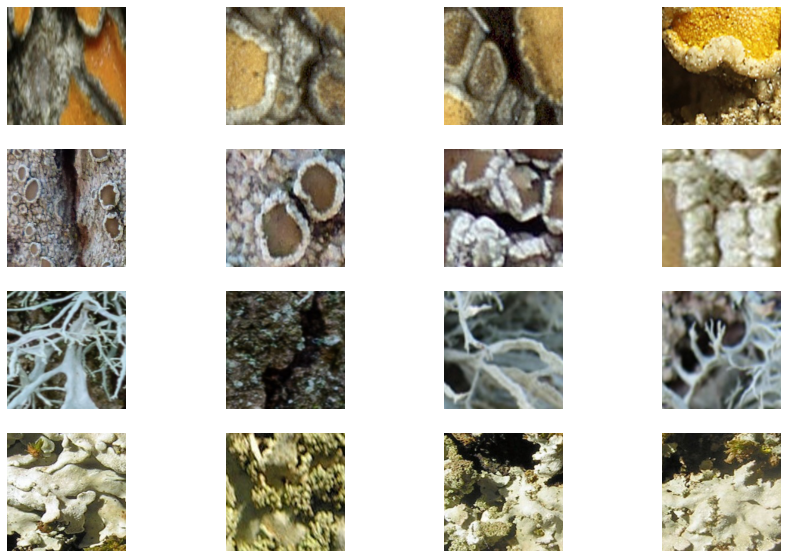

In [6]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = lichens_dataframe['image'][lichens_dataframe['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(4,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

In [ ]:
%mkdir -p data/train
%mkdir -p data/valid

In [ ]:

current_dir_train = join(getcwd(),'data/train')
current_dir_val = join(getcwd(),'data/valid')

for sp in species:
    join(current_dir_train),sp
    makedirs(join(current_dir_train,sp))

In [ ]:
current_dir_val = join(getcwd(),'data/valid')

for sp in species:
    join(current_dir_val),sp
    makedirs(join(current_dir_val,sp))

In [ ]:
# move 75% of the images in training direcory and the remaining in the validation directory
for category in fl_count.index:
    samples =lichens_dataframe['image'][lichens_dataframe['category'] == category].values
    tr_num = len(samples)*75//100
    perm = np.random.permutation(samples)
    for i in range(tr_num):
        print(i)
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'data/train/'+ str(category) + '/' + name)
    print('*****************************************************')
    for i in range(tr_num,len(samples)):
        print(i)
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'data/valid/'+ str(category) + '/' + name)       
    

# USING PRE-TRAINED CONVNET

In [7]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (100, 100, 3))

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

# FEATURE EXTRACTION 

We can extract features of our images dataset using a pretrained model. This is called Feature Extraction. There are 2 ways to use this method, first one doesn't support data augmentation, but however the second method is usable with data augmentation.

In [9]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 16

## NO DATA AUGMENTATION

In [10]:
# write a function which extracts features, and then train an SVM or another neural network

current_dir_train = join(getcwd(),'data/train')
current_dir_val = join(getcwd(),'data/valid')
def feature_extraction(directory, sample_count):
    
    # pre_allocated memory
    #features = []
    #labels_dummy = []
    features = np.zeros(shape = (sample_count,3,3,512))
    labels_dummy = np.zeros(shape = (sample_count,20))
    labels =np.zeros(shape = (sample_count,1))
    
    generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(directory, target_size = (100, 100), 
                                                                            batch_size = batch_size, class_mode = 'categorical')
    
    
    
    i = 0
    
    
    print('enter in loop')
    
    for input_batch, labels_batch in generator:
        
        features_batch = conv_base.predict(input_batch)
        features[i*batch_size : (i + 1)*batch_size] = features_batch 
        labels_dummy[i*batch_size : (i + 1)*batch_size] = labels_batch
        #features.append(features_batch)
        #labels_dummy.append(labels_batch)
        
        i = i + 1
        
        if i*batch_size >= sample_count:
            break
    
    
    #features = np.array(features)
    #labels_dummy = np.array(labels_dummy)
    return features, labels_dummy
    
    
    
train_features, train_labels_dummy = feature_extraction(current_dir_train, 1200)   
    
validation_features, validation_labels_dummy = feature_extraction(current_dir_val, 400)   



    
    

Found 1200 images belonging to 20 classes.
enter in loop
Found 400 images belonging to 20 classes.
enter in loop


In [11]:
# create labels vector 
def from_dummy_to_labels(dummy_vec):
    res = np.zeros(dummy_vec.shape[0])
    for i in range(dummy_vec.shape[0]):
        tmp = list(dummy_vec[i])
        res[i] = tmp.index(1)
    return res

In [12]:
training_labels = from_dummy_to_labels(train_labels_dummy)
validation_labels = from_dummy_to_labels(validation_labels_dummy)

train_features = np.reshape(train_features, (1200, 3 * 3 * 512))
validation_features = np.reshape(validation_features, (400, 3 * 3 * 512))

## TRAIN A SVM MODEL  WITH EXTRACTED FEATURES!

In [16]:



svc, _ , _ = define_svm.define_and_train_svm(train_features, training_labels, 'linear')
svc.score(validation_features,validation_labels)



here


0.705

## FINE-TUNING

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(100, 100),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(100, 100),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

In [ ]:
conv_base.summary()

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(20, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(lr=2e-5),metrics=['acc'])

In [ ]:
istory = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=6,
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
acc = istory.history['acc']
val_acc = istory.history['val_acc']
loss = istory.history['loss']
val_loss = istory.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
#plot_confusion_matrix(cm = con_mat, classes = validation_generator.class_indices.keys(), normalize = False)